In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:27:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest AUC: 0.9840035444397229
XGBoost AUC: 0.9838511938258702

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.62      0.89      0.73        98

    accuracy                           1.00     56962
   macro avg       0.81      0.94      0.86     56962
weighted avg       1.00      1.00      1.00     56962


Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.87      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

The better model is: Random Forest


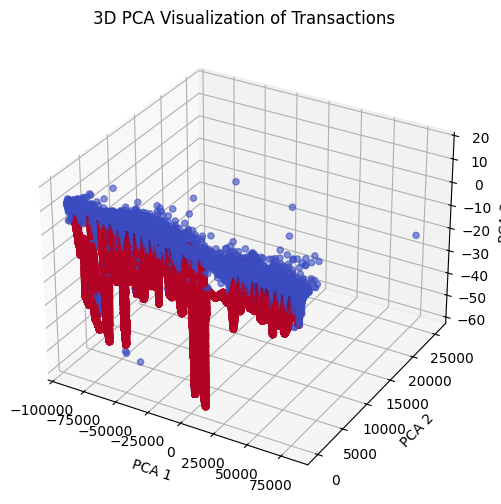

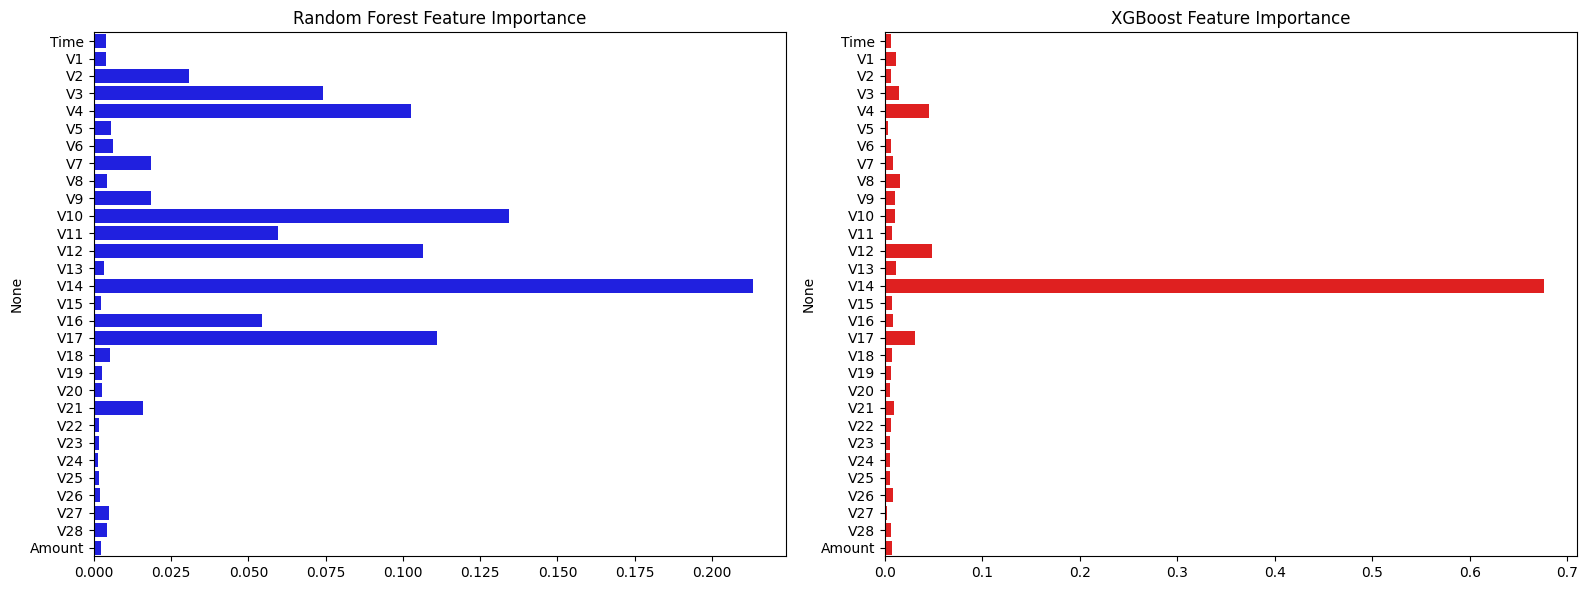

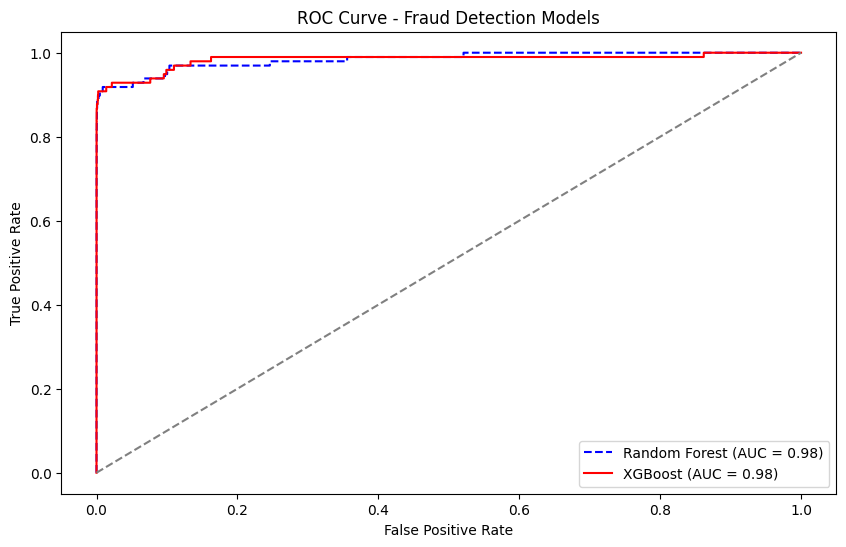

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_recall_curve, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Load dataset
data = pd.read_csv("creditcard.csv")

# Drop rows where 'Class' is NaN
data = data.dropna(subset=['Class'])

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Ensure there are no NaNs in features as well
X = X.fillna(X.median())

# Split data before applying SMOTE (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Address imbalance using SMOTE on training set only
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

# Train XGBoost Model
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)

# Compare Models
print("Random Forest AUC:", rf_auc)
print("XGBoost AUC:", xgb_auc)
print("\nClassification Report (Random Forest):\n", classification_report(y_test, rf_preds))
print("\nClassification Report (XGBoost):\n", classification_report(y_test, xgb_preds))

# Identify the better model
best_model = "XGBoost" if xgb_auc > rf_auc else "Random Forest"
print(f"The better model is: {best_model}")

# 3D PCA Visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_resampled)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train_resampled, cmap='coolwarm', alpha=0.6)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('3D PCA Visualization of Transactions')
plt.show()

# Feature Importance Comparison
rf_importance = rf_model.feature_importances_
xgb_importance = xgb_model.feature_importances_
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=rf_importance, y=features, ax=ax[0], color='blue')
ax[0].set_title("Random Forest Feature Importance")
sns.barplot(x=xgb_importance, y=features, ax=ax[1], color='red')
ax[1].set_title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# ----------- ROC Curve for Comparison -----------
plt.figure(figsize=(10, 6))

# Compute ROC curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# Plot ROC Curve
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', linestyle='--', color='blue')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})', linestyle='-', color='red')

# Add Reference Line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Labels & Title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fraud Detection Models')
plt.legend()
plt.show()
